# Wiset ICT Project - Bin packing
- based code: https://github.com/enzoruiz/3dbinpacking
- written by Kyunghee(Kira) Jung
- 필요한 부분은 주석으로 설명해뒀습니다

In [1]:
# The code below is written by enzoruiz
from decimal import Decimal

DEFAULT_NUMBER_OF_DECIMALS = 3
START_POSITION = [0, 0, 0]


class RotationType:
    RT_WHD = 0
    RT_HWD = 1
    RT_HDW = 2
    RT_DHW = 3
    RT_DWH = 4
    RT_WDH = 5

    ALL = [RT_WHD, RT_HWD, RT_HDW, RT_DHW, RT_DWH, RT_WDH]


class Axis:
    WIDTH = 0
    HEIGHT = 1
    DEPTH = 2

    ALL = [WIDTH, HEIGHT, DEPTH]


    
def rect_intersect(item1, item2, x, y):
    d1 = item1.get_dimension()
    d2 = item2.get_dimension()

    cx1 = item1.position[x] + d1[x]/2
    cy1 = item1.position[y] + d1[y]/2
    cx2 = item2.position[x] + d2[x]/2
    cy2 = item2.position[y] + d2[y]/2

    ix = max(cx1, cx2) - min(cx1, cx2)
    iy = max(cy1, cy2) - min(cy1, cy2)

    return ix < (d1[x]+d2[x])/2 and iy < (d1[y]+d2[y])/2


def intersect(item1, item2):
    return (
        rect_intersect(item1, item2, Axis.WIDTH, Axis.HEIGHT) and
        rect_intersect(item1, item2, Axis.HEIGHT, Axis.DEPTH) and
        rect_intersect(item1, item2, Axis.WIDTH, Axis.DEPTH)
    )


def get_limit_number_of_decimals(number_of_decimals):
    return Decimal('1.{}'.format('0' * number_of_decimals))


def set_to_decimal(value, number_of_decimals):
    number_of_decimals = get_limit_number_of_decimals(number_of_decimals)

    return Decimal(value).quantize(number_of_decimals)



class Item:
    def __init__(self, name, width, height, depth, weight):
        self.name = name
        self.width = width
        self.height = height
        self.depth = depth
        self.weight = weight
        self.rotation_type = 0
        self.position = START_POSITION
        self.number_of_decimals = DEFAULT_NUMBER_OF_DECIMALS

    def format_numbers(self, number_of_decimals):
        self.width = set_to_decimal(self.width, number_of_decimals)
        self.height = set_to_decimal(self.height, number_of_decimals)
        self.depth = set_to_decimal(self.depth, number_of_decimals)
        self.weight = set_to_decimal(self.weight, number_of_decimals)
        self.number_of_decimals = number_of_decimals

    def string(self):
        return "%s(%sx%sx%s, weight: %s) pos(%s) rt(%s) vol(%s)" % (
            self.name, self.width, self.height, self.depth, self.weight,
            self.position, self.rotation_type, self.get_volume()
        )
    
    # 제작
    def get_position(self):
        return self.position

    def get_volume(self):
        return set_to_decimal(
            self.width * self.height * self.depth, self.number_of_decimals
        )

    def get_dimension(self):
        if self.rotation_type == RotationType.RT_WHD:
            dimension = [self.width, self.height, self.depth]
        elif self.rotation_type == RotationType.RT_HWD:
            dimension = [self.height, self.width, self.depth]
        elif self.rotation_type == RotationType.RT_HDW:
            dimension = [self.height, self.depth, self.width]
        elif self.rotation_type == RotationType.RT_DHW:
            dimension = [self.depth, self.height, self.width]
        elif self.rotation_type == RotationType.RT_DWH:
            dimension = [self.depth, self.width, self.height]
        elif self.rotation_type == RotationType.RT_WDH:
            dimension = [self.width, self.depth, self.height]
        else:
            dimension = []

        return dimension


class Bin:
    def __init__(self, name, width, height, depth, max_weight):
        self.name = name
        self.width = width
        self.height = height
        self.depth = depth
        self.max_weight = max_weight
        self.items = []
        self.unfitted_items = []
        self.number_of_decimals = DEFAULT_NUMBER_OF_DECIMALS

    def format_numbers(self, number_of_decimals):
        self.width = set_to_decimal(self.width, number_of_decimals)
        self.height = set_to_decimal(self.height, number_of_decimals)
        self.depth = set_to_decimal(self.depth, number_of_decimals)
        self.max_weight = set_to_decimal(self.max_weight, number_of_decimals)
        self.number_of_decimals = number_of_decimals

    def string(self):
        return "%s(%sx%sx%s, max_weight:%s) vol(%s)" % (
            self.name, self.width, self.height, self.depth, self.max_weight,
            self.get_volume()
        )

    def get_volume(self):
        return set_to_decimal(
            self.width * self.height * self.depth, self.number_of_decimals
        )

    def get_total_weight(self):
        total_weight = 0

        for item in self.items:
            total_weight += item.weight

        return set_to_decimal(total_weight, self.number_of_decimals)
    


    def put_item(self, item, pivot):
        fit = False
        valid_item_position = item.position
        item.position = pivot

        for i in range(0, len(RotationType.ALL)):
            item.rotation_type = i
            dimension = item.get_dimension()
            if (
                self.width < pivot[0] + dimension[0] or
                self.height < pivot[1] + dimension[1] or
                self.depth < pivot[2] + dimension[2]
            ):
                continue

            fit = True

            for current_item_in_bin in self.items:
                if intersect(current_item_in_bin, item):
                    fit = False
                    break

            if fit:
                if self.get_total_weight() + item.weight > self.max_weight:
                    fit = False
                    return fit

                self.items.append(item)

            if not fit:
                item.position = valid_item_position

            return fit

        if not fit:
            item.position = valid_item_position

        return fit


class Packer:
    def __init__(self):
        self.bins = []
        self.items = []
        self.unfit_items = []
        self.total_items = 0

    def add_bin(self, bin):
        return self.bins.append(bin)

    def add_item(self, item):
        self.total_items = len(self.items) + 1

        return self.items.append(item)

    def pack_to_bin(self, bin, item):
        fitted = False

        if not bin.items:
            response = bin.put_item(item, START_POSITION)

            if not response:
                bin.unfitted_items.append(item)

            return

        for axis in range(0, 3):
            items_in_bin = bin.items

            for ib in items_in_bin:
                pivot = [0, 0, 0]
                w, h, d = ib.get_dimension()
                if axis == Axis.WIDTH:
                    pivot = [
                        ib.position[0] + w,
                        ib.position[1],
                        ib.position[2]
                    ]
                elif axis == Axis.HEIGHT:
                    pivot = [
                        ib.position[0],
                        ib.position[1] + h,
                        ib.position[2]
                    ]
                elif axis == Axis.DEPTH:
                    pivot = [
                        ib.position[0],
                        ib.position[1],
                        ib.position[2] + d
                    ]

                if bin.put_item(item, pivot):
                    fitted = True
                    break
            if fitted:
                # print('if fitted: {0}, {1}, {2}'.format(ib.position[0], ib.position[1], ib.position[2]))
                break

        if not fitted:
            bin.unfitted_items.append(item)

    def pack(
        # distribute_itesm=True : put the items in the bins that at least one item be in one bin that can be fitted.
        self, bigger_first=False, distribute_items=False,
        number_of_decimals=DEFAULT_NUMBER_OF_DECIMALS
    ):
        for bin in self.bins:
            bin.format_numbers(number_of_decimals)

        for item in self.items:
            item.format_numbers(number_of_decimals)

        self.bins.sort(
            key=lambda bin: bin.get_volume(), reverse=bigger_first
        )
        self.items.sort(
            key=lambda item: item.get_volume(), reverse=bigger_first
        )

        for bin in self.bins:
            for item in self.items:
                self.pack_to_bin(bin, item)

            if distribute_items:
                for item in bin.items:
                    self.items.remove(item)


## You can change Options for Bins and Items from here
- 필요한 부분은 주석으로 설명해뒀습니다

In [2]:
packer = Packer()

### Change numbers below to limit the size of bin ###
### The last option is the limit of weight ###
### It might be necessary for our project ###
# packer.add_bin(Bin('Truck1', 10, 10, 3, 1000))
# packer.add_bin(Bin('Truck2', 5, 8, 10, 10))
# packer.add_bin(Bin('Truck3', 5, 5, 5, 10))
# packer.add_bin(Bin('Truck4', 10, 10, 10, 10))
# packer.add_bin(Bin('Truck5', 10, 10, 10, 10))

packer.add_bin(Bin('small-envelope', 11.5, 6.125, 0.25, 10))
packer.add_bin(Bin('large-envelope', 15.0, 12.0, 0.75, 15))
packer.add_bin(Bin('small-box', 8.625, 5.375, 1.625, 70.0))
packer.add_bin(Bin('medium-box', 11.0, 8.5, 5.5, 70.0))
packer.add_bin(Bin('medium-2-box', 13.625, 11.875, 3.375, 70.0))
packer.add_bin(Bin('large-box', 12.0, 12.0, 5.5, 70.0))
packer.add_bin(Bin('large-2-box', 23.6875, 11.75, 3.0, 70.0))




### Change numbers below to set the size of Item ###
### The last option is also the weight of the Item ###
# packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
# packer.add_item(Item('50g [powder 2]', 3.9370, 1.9685, 1.9685, 2))
# packer.add_item(Item('50g [powder 3]', 3.9370, 1.9685, 1.9685, 3))
# packer.add_item(Item('250g [powder 4]', 7.8740, 3.9370, 1.9685, 4))
# packer.add_item(Item('250g [powder 5]', 7.8740, 3.9370, 1.9685, 5))
# packer.add_item(Item('250g [powder 6]', 7.8740, 3.9370, 1.9685, 6))
# packer.add_item(Item('250g [powder 7]', 7.8740, 3.9370, 1.9685, 7))
# packer.add_item(Item('250g [powder 8]', 7.8740, 3.9370, 1.9685, 8))
# packer.add_item(Item('250g [powder 9]', 7.8740, 3.9370, 1.9685, 9))

packer.add_item(Item('1', 3, 3, 3, 0))
packer.add_item(Item('2', 3, 3, 3, 0))
packer.add_item(Item('3', 1, 1, 1, 0))
packer.add_item(Item('4', 1, 1, 1, 0))
packer.add_item(Item('5', 1, 1, 1, 0))



### This is for actual Packing, you can check whether the item is fitted or not. ###
packer.pack()

for b in packer.bins:
    print(":::::::::::", b.string())

    print("FITTED ITEMS:")
    for item in b.items:
        print("====> ", item.string())

    print("UNFITTED ITEMS:")
    for item in b.unfitted_items:
        print("====> ", item.string())

    print("***************************************************")
    print("\n\n")

::::::::::: small-envelope(11.500x6.125x0.250, max_weight:10.000) vol(17.609)
FITTED ITEMS:
UNFITTED ITEMS:
====>  3(1.000x1.000x1.000, weight: 0.000) pos([0, 0, 0]) rt(0) vol(1.000)
====>  4(1.000x1.000x1.000, weight: 0.000) pos([Decimal('1.000'), 0, 0]) rt(0) vol(1.000)
====>  5(1.000x1.000x1.000, weight: 0.000) pos([Decimal('2.000'), 0, 0]) rt(0) vol(1.000)
====>  1(3.000x3.000x3.000, weight: 0.000) pos([Decimal('3.000'), 0, 0]) rt(0) vol(27.000)
====>  2(3.000x3.000x3.000, weight: 0.000) pos([Decimal('6.000'), 0, 0]) rt(0) vol(27.000)
***************************************************



::::::::::: small-box(8.625x5.375x1.625, max_weight:70.000) vol(75.334)
FITTED ITEMS:
====>  3(1.000x1.000x1.000, weight: 0.000) pos([0, 0, 0]) rt(0) vol(1.000)
====>  4(1.000x1.000x1.000, weight: 0.000) pos([Decimal('1.000'), 0, 0]) rt(0) vol(1.000)
====>  5(1.000x1.000x1.000, weight: 0.000) pos([Decimal('2.000'), 0, 0]) rt(0) vol(1.000)
UNFITTED ITEMS:
====>  1(3.000x3.000x3.000, weight: 0.000) 

## Visualizing

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import numpy as np

### Colored and Not_Colored cube Visualizing Definition
- 입력 변수 맞춰서 다른 코드에서 그대로 사용하셔도 됩니다

In [4]:
def colored_cube(cube_definition, color, edge_color):
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]

    faces = Poly3DCollection(edges, linewidths=1, edgecolors=edge_color, alpha=0.1)
    faces.set_facecolor(color)

    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('auto')


def not_colored_cube(x, y, z, dx, dy, dz, color, alpha):    
    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    kwargs = {'alpha': alpha, 'color': color, 'linewidth':1}
    ax.plot3D(xx, yy, [z]*5, **kwargs)
    ax.plot3D(xx, yy, [z+dz]*5, **kwargs)
    ax.plot3D([x, x], [y, y], [z, z+dz], **kwargs)
    ax.plot3D([x, x], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y, y], [z, z+dz], **kwargs)

### 색칠되게 그리기

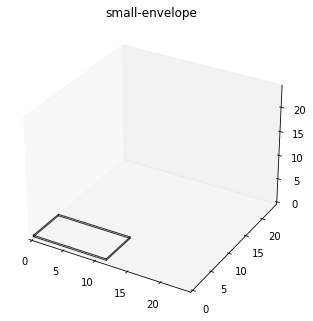

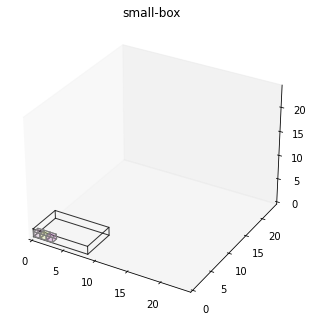

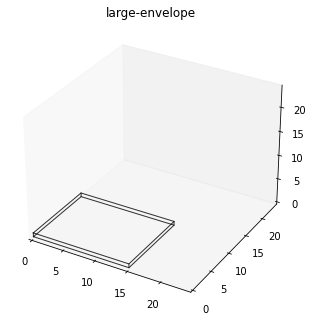

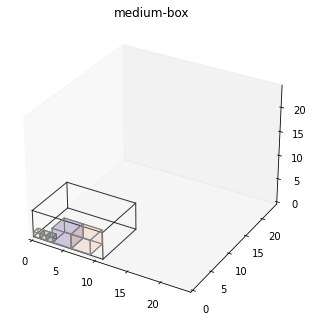

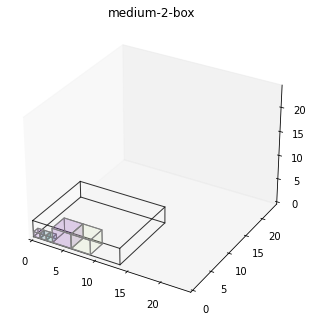

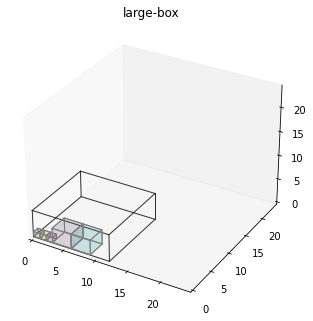

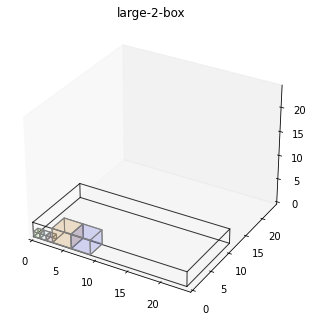

In [5]:
for b in packer.bins:
    fig = plt.figure(figsize=(4, 4))
    
    ax = Axes3D(fig)
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 24)
    ax.set_zlim(0, 24)
    ax.grid(False)
    
    plt.title(b.name)
    bin_definition = [
        (-0.05, -0.05, -0.05),
        (0, float(b.width)+0.05, 0),
        (float(b.height)+0.05, 0, 0),
        (0, 0, float(b.depth)+0.05)
    ]
    #colored_cube(bin_definition, (0,0,1,0.1), 'gray') # colored 쓰려면 주석 제거 하세요
    not_colored_cube(-0.05, -0.05, -0.05, float(b.width)+0.05, float(b.height)+0.05, float(b.depth)+0.05, 'BLACK', 0.8)
    #print(b.name, "\t| Fitted Items:")
    for item in b.items:
        dimension = item.get_dimension()
        item_definition = [
            (float(item.get_position()[0]), float(item.get_position()[1]), float(item.get_position()[2])),
            (float(item.get_position()[0]), float(item.get_position()[1])+float(dimension[1]), float(item.get_position()[2])),
            (float(item.get_position()[0])+float(dimension[0]), float(item.get_position()[1]), float(item.get_position()[2])),
            (float(item.get_position()[0]), float(item.get_position()[1]), float(item.get_position()[2])+float(dimension[2]))
        ]
        colored_cube(item_definition, np.random.rand(3,), 'gray')

### 선으로만 그리기

small-envelope 	| Fitted Items:
small-box 	| Fitted Items:
3(1.000x1.000x1.000, weight: 0.000) pos([0, 0, 0]) rt(0) vol(1.000) 

4(1.000x1.000x1.000, weight: 0.000) pos([Decimal('1.000'), 0, 0]) rt(0) vol(1.000) 

5(1.000x1.000x1.000, weight: 0.000) pos([Decimal('2.000'), 0, 0]) rt(0) vol(1.000) 

large-envelope 	| Fitted Items:
medium-box 	| Fitted Items:
3(1.000x1.000x1.000, weight: 0.000) pos([0, 0, 0]) rt(0) vol(1.000) 

4(1.000x1.000x1.000, weight: 0.000) pos([Decimal('1.000'), 0, 0]) rt(0) vol(1.000) 

5(1.000x1.000x1.000, weight: 0.000) pos([Decimal('2.000'), 0, 0]) rt(0) vol(1.000) 

1(3.000x3.000x3.000, weight: 0.000) pos([Decimal('3.000'), 0, 0]) rt(0) vol(27.000) 

2(3.000x3.000x3.000, weight: 0.000) pos([Decimal('6.000'), 0, 0]) rt(0) vol(27.000) 

medium-2-box 	| Fitted Items:
3(1.000x1.000x1.000, weight: 0.000) pos([0, 0, 0]) rt(0) vol(1.000) 

4(1.000x1.000x1.000, weight: 0.000) pos([Decimal('1.000'), 0, 0]) rt(0) vol(1.000) 

5(1.000x1.000x1.000, weight: 0.000) pos([Dec

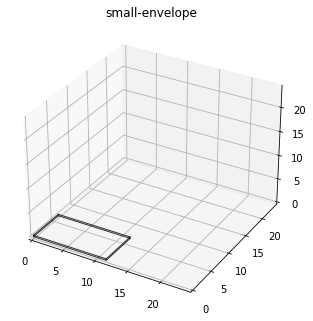

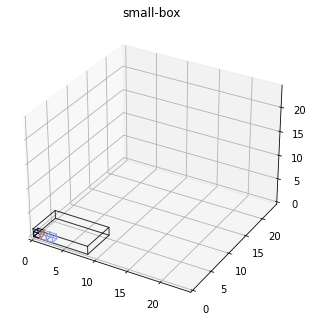

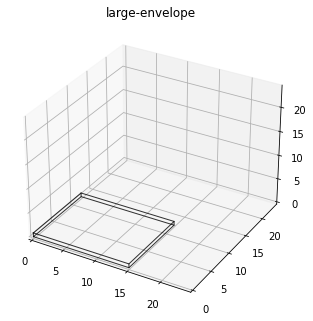

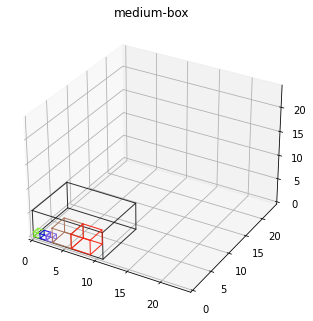

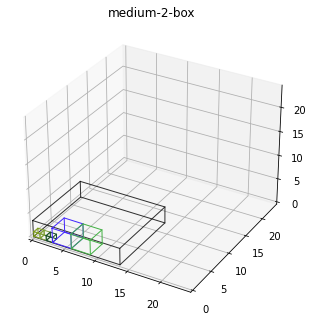

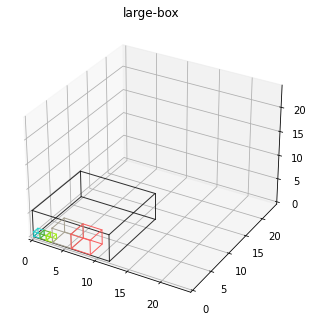

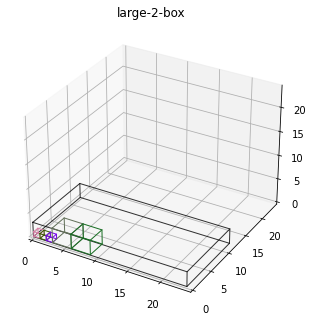

In [6]:
for b in packer.bins:
    fig = plt.figure(figsize=(4, 4))
    
    #plt.zlim([0,20])
    ax = Axes3D(fig)
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 24)
    ax.set_zlim(0, 24)
    
    plt.title(b.name)
    
    not_colored_cube(-0.05, -0.05, -0.05, float(b.width)+0.05, float(b.height)+0.05, float(b.depth)+0.05, 'BLACK', 0.8)
    print(b.name, "\t| Fitted Items:")
    for item in b.items:
        print(item.string(), '\n')
        dimension = item.get_dimension()
        not_colored_cube(float(item.get_position()[0]), float(item.get_position()[1]), float(item.get_position()[2]),
        float(dimension[0]), float(dimension[0]), float(dimension[0]), np.random.rand(3,), 1)
#         draw_item(float(item.get_position()[0]), float(item.get_position()[1]), float(item.get_position()[2]),
#         float(item.width), float(item.height), float(item.depth), np.random.rand(3,), 1)
        